#Project of 'Laboratorio di Intelligenza Artificiale'
Nevi Classification with Machine Learninig for automatic diagnosis of melanoma

[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=purple)](https://github.com/ValerioSpagnoli/Nevi-Classification/blob/main/Nevi_Classification.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1e4YtGOXGq-ZCI5Iun__t99Y4HTTMuQXa?authuser=1#scrollTo=uQbBFaezBVRa)

##Import, mount on Google Drive, definition of variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import optimizer
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset
import torchvision
from torchvision.models import resnet
from torchvision.models.resnet import ResNet18_Weights
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torchaudio

import pandas as pd

import os

from skimage import io
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from google.colab import files

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
batch_size = 16
num_epochs = 10
num_epochs_bld = 13
classes = ('benign', 'malignant')

##Class of Dataset and Loader

In [ ]:
class ISIC_Dataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None, data=None, device=None):
    self.img_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform
    self.data = data
    self.code_img = None
    self.device = device

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    self.code_img = self.img_labels.iloc[idx, 0]
    img_path = os.path.join(self.img_dir, self.code_img) + '.jpg'
    image = io.imread(img_path)

    #benign = 0 malignant = 1
    
    if(self.data == 'Train'):
      label_bm = self.img_labels.iloc[idx, 1]
      label = 0
      if(label_bm == 'malignant'): 
        label = 1

    elif(self.data == 'Test'):
      label = self.img_labels.iloc[idx, 1].astype(np.int64)


    if self.transform:
      image = self.transform(image)

    image.to(self.device)

    return image, label

In [ ]:
def get_trainloader(batch_size = None, balanced = None, augment = None):

  loader = None
  dataset = None

  transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  #dataset = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
  #                      img_dir = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data', 
  #                      transform = transform, data = "Train", device = device)
  
  dataset = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
                        img_dir = '/content/drive/MyDrive/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data', 
                        transform = transform, data = "Train", device = device)
  

  if augment == True:

    transform_aug = transforms.Compose([transforms.ToPILImage(),
                                    transforms.AutoAugment(policy = AutoAugmentPolicy.IMAGENET),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    #dataset = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
    #                      img_dir = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data', 
    #                      transform = transform_aug, data = "Train", device = device)
    
    dataset_aug = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
                          img_dir = '/content/drive/MyDrive/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data', 
                          transform = transform_aug, data = "Train", device = device)
    

    dataset = ConcatDataset([dataset, dataset_aug])
    


  if balanced == True:
      
    class_weights = [1, 4]
    sample_weights = [0] * len(dataset)

    for idx, (image, label) in enumerate(dataset):
      class_weight = class_weights[label]
      sample_weights[idx] = class_weight

    sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)
    
    loader = DataLoader(dataset, batch_size = batch_size, sampler = sampler)

  else:

    loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


  if(dataset == None or loader == None or (dataset == None and loader == None)):
    print("Errore nel setup del loader.")
    return

  return loader, dataset

In [ ]:
def get_testloader(batch_size = None, balanced = None):

  loader = None
  dataset = None
  transform = None
    
  transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    

  #dataset = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
  #                      img_dir = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data', 
  #                      transform = transform, data = "Test", device = device)
  
  dataset = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
                        img_dir = '/content/drive/MyDrive/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data', 
                        transform = transform, data = "Test", device = device)


  if balanced == True:
      
    class_weights = [1, 4]
    sample_weights = [0] * len(dataset)

    for idx, (image, label) in enumerate(dataset):
      class_weight = class_weights[label]
      sample_weights[idx] = class_weight

    sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)
    
    loader = DataLoader(dataset, batch_size = batch_size, sampler = sampler)

  else:

    loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


  if(dataset == None or loader == None or (dataset == None and loader == None)):
    print("Errore nel setup del loader.")
    return

  return loader, dataset

In [ ]:
def stat_dataframe(csv_path = None):
  df = pd.read_csv(csv_path)
  
  print("Le prime 5 righe del dataset:\n")
  print(df.head())
  print("\n\n")
  
  print("Descrizione del dataset:\n")
  print(df.describe())
  print("\n\n")

  print("Percentuale di benigni e maligni nel dataframe:\n")
  print(df['benign'].value_counts(normalize=True))
  bn = df['benign']
  sns.displot(bn)
  print("\n\n")

  print("Numero di valori nulli del dataset:\n")
  print(df.isna().sum())
  print("\n\n")

In [91]:
def stat_loader(data_type = None, loader = None):
  num_benign = 0
  num_malignant = 0

  for i, data in enumerate(loader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      for j in range(labels.size()[0]):
        if(labels[j] == 0):
          num_benign += 1
        else:
          num_malignant += 1

  print("Loader shape:", data_type+"_loader: ", num_benign+num_malignant, "\n\n")

  print("Percentage of benign and malignant nevi in ​​the loader:\n")
  print("benign:", num_benign/(num_benign+num_malignant))
  print("malignant:", num_malignant/(num_benign+num_malignant), "\n\n")

  print("About images:\n")
  train_features, train_labels = next(iter(train_loader))
  print(f"Feature batch shape: {train_features.size()}")
  print(f"Labels batch shape: {train_labels.size()}", "\n\n")

  print("Printing a batch of images:\n")

  dataiter = iter(loader)
  images, labels = dataiter.next()

  imshow(torchvision.utils.make_grid(images))

  for i in range(0, batch_size):
    if(labels[i]==0):
      print(i, 'benign')
    else:
      print(i, 'malignant')

In [ ]:
def imshow(img):
    img[0] = img[0]*0.485 + 0.229     # unnormalize
    img[1] = img[1]*0.456 + 0.224
    img[2] = img[2]*0.406 + 0.225
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

##Model, Training and Testing

In [ ]:
def get_model():
  model =  torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
  for params in model.parameters():
    params.requires_grad_ = False

  nr_filters = model.fc.in_features
  model.fc = nn.Linear(nr_filters, 1)

  model.to(device)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
  return model, criterion, optimizer

In [ ]:
def training(model = None, criterion = None, optimizer = None):

  model, criterion, optimizer = model, criterion, optimizer

  total_train_loss = []
  total_train_acc = []

  total_prediction = 0
  correct_prediction = 0

  total_loss = 0

  print('--- Start Training ---')

  for epoch in range(num_epochs):  # loop over the dataset multiple times

    print("\n\n--------- Epoch", epoch, "---------")

    total_prediction_epoch = 0
    correct_prediction_epoch = 0

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      outputs = torch.transpose(outputs,-1,0)[0]

      loss = criterion(outputs, labels.float())

      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      outputs = torch.sigmoid(outputs)
      prediction = []
      target = []

      for j in range(0, labels.size()[0]):
        out = 0 #benign
        if(outputs[j]>=0.5):
          out = 1 #malignant
        
        lab = labels[j]

        prediction.append(out)
        target.append(lab.item())

        if(lab == out):
          correct_prediction_epoch += 1
          correct_prediction += 1

        total_prediction_epoch += 1
        total_prediction += 1
      #print("--- Iteration: ", i, "\n")
      #print("--- Target:    ", target, "\n")
      #print("--- Prediction:", prediction, "\n\n")
        
    loss_epoch = round(running_loss/len(train_loader), 5)
    total_loss += loss_epoch
    total_train_loss.append(loss_epoch)
    accuracy_epoch = round(correct_prediction_epoch/total_prediction_epoch * 100, 5)
    total_train_acc.append(accuracy_epoch)

    print("\nLoss:", loss_epoch, " --  Accuracy:", accuracy_epoch, "\n")

  final_accuracy = correct_prediction/total_prediction * 100
  final_loss = total_loss / len(train_loader)

  print("\n-------------------------------------------------------------------------\n\n")
  print("Final Loss:", round(final_loss,5), "-- Final Accuracy:", round(final_accuracy,5))


  print('\n--- Finished Training ---')

  return total_train_loss, total_train_acc



In [ ]:
def testing(model = None, criterion = None, optimizer = None, total_train_loss = None, total_train_acc = None):

  model, criterion, optimizer = model, criterion, optimizer


  total_prediction = 0
  correct_prediction = 0

  with torch.no_grad():

    for i, data in enumerate(test_loader, 0):

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      #outputs = net(inputs)
      outputs = model(inputs)
      outputs = torch.sigmoid(outputs) 

      for j in range(0, labels.size()[0]):
        out = 0
        if(outputs[j]>=0.5):
          out = 1

        lab = labels[j]

        if(lab == out):
          correct_prediction += 1

        total_prediction += 1
        
    final_accuracy = round(correct_prediction/total_prediction * 100, 2)

  print("Test Accuracy:", final_accuracy, "%")

  benign_correct = 0
  benign_total = 0
  malignant_correct = 0
  malignant_total = 0

  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          outputs = torch.sigmoid(outputs) 
          
          for i in range(0, labels.size()[0]):
            
            if(labels[i] == 0): # benign
              benign_total += 1
              if(outputs[i]<0.5):
                benign_correct += 1

            elif(labels[i] == 1): # benign
              malignant_total += 1
              if(outputs[i]>=0.5):
                malignant_correct += 1

  print('Accuracy of "benign" on test images: %d %%' % (100 * benign_correct / benign_total))
  print('Accuracy of "malignant" on test images: %d %%' % (100 * malignant_correct / malignant_total))

  
  Y = []
  Y_hat = []
  X_test = []

  total_train_loss = total_train_loss
  total_train_acc = total_train_acc

  with torch.no_grad():
    for data in test_loader:
        images, label = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        for i in range(0, labels.size()[0]):
          Y.append(labels[i].item())
          if(torch.sigmoid(outputs[i][0]).item()<0.5):
            Y_hat.append(0)
          else:
            Y_hat.append(1)
        

  #print(Y)
  #print(Y_hat)

  cm = confusion_matrix(Y, Y_hat)
  plt.figure()
  sns.set(font_scale=1.5)
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=['0', '1'], xticklabels=['0', '1'])
  plt.title('Confusion Matrix')
  plt.ylabel('Ground Truth')
  plt.xlabel('Prediction')
  plt.show()

  plt.plot(total_train_loss, label = 'training loss')
  plt.legend()
  plt.plot(total_train_acc, label = 'training accuracy')
  plt.legend()
  plt.figure(figsize=(20, 14), dpi=80)
  plt.show()

In [ ]:
def test_on_1batch(test_loader = None, model = None):

  dataiter = iter(test_loader)
  images, labels = dataiter.next()

  imshow(torchvision.utils.make_grid(images))
  
  images, labels = images.to(device), labels.to(device)

  outputs = model(images)
  outputs = torch.sigmoid(outputs)

  out = []

  for elem in outputs:
    if elem.item() >= 0.5:
      out.append(1)
    elif elem.item() < 0.5:
      out.append(0)

  print("idx | Ground Truth | Prediction")
  print("----|--------------|-----------")

  for i in range(0, batch_size):
    print(i, "  |" if i < 10 else " |", classes[labels[i]]+"     " if labels[i] == 0 else classes[labels[i]]+"  ", " |", classes[out[i]])

##Nevi Classification

Le prime 5 righe del dataset:

   ISIC_0000000     benign
0  ISIC_0000001     benign
1  ISIC_0000002  malignant
2  ISIC_0000004  malignant
3  ISIC_0000006     benign
4  ISIC_0000007     benign



Descrizione del dataset:

        ISIC_0000000  benign
count            899     899
unique           899       2
top     ISIC_0000001  benign
freq               1     726



Percentuale di benigni e maligni nel dataframe:

benign       0.807564
malignant    0.192436
Name: benign, dtype: float64



Numero di valori nulli del dataset:

ISIC_0000000    0
benign          0
dtype: int64





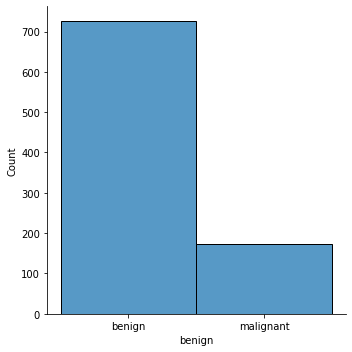

In [ ]:
#stat_dataframe('/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv')
stat_dataframe('/content/drive/MyDrive/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv')

In [ ]:
train_loader, train_set = get_trainloader(batch_size = batch_size, balanced = True, augment = True)

In [ ]:
test_loader, test_set = get_trainloader(batch_size = batch_size, balanced = True)

Loader shape: Train_loader:  1798 


Percentage of benign and malignant nevi in ​​the loader:

benign: 0.5061179087875417
malignant: 0.4938820912124583 


About images:

Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: torch.Size([16]) 


Printing a batch of images:



0 benign
1 benign
2 malignant
3 benign
4 benign
5 malignant
6 malignant
7 benign
8 benign
9 malignant
10 benign
11 benign
12 malignant
13 benign
14 benign
15 malignant


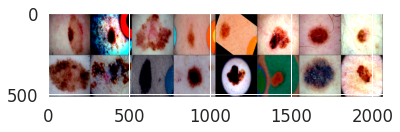

In [92]:
stat_loader(data_type = "Train", loader = train_loader)

In [ ]:
model, criterion, optimizer = get_model()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
total_train_loss, total_train_acc = training(model = model, criterion = criterion, optimizer = optimizer)

--- Start Training ---


--------- Epoch 0 ---------

Loss: 0.54532  --  Accuracy: 71.02336 



--------- Epoch 1 ---------

Loss: 0.39491  --  Accuracy: 82.14683 



--------- Epoch 2 ---------

Loss: 0.29534  --  Accuracy: 87.76418 



--------- Epoch 3 ---------

Loss: 0.24353  --  Accuracy: 89.76641 



--------- Epoch 4 ---------

Loss: 0.21746  --  Accuracy: 90.43382 



--------- Epoch 5 ---------

Loss: 0.1745  --  Accuracy: 93.04783 



--------- Epoch 6 ---------

Loss: 0.14473  --  Accuracy: 94.32703 



--------- Epoch 7 ---------

Loss: 0.15043  --  Accuracy: 93.77086 



--------- Epoch 8 ---------

Loss: 0.11987  --  Accuracy: 95.43938 



--------- Epoch 9 ---------

Loss: 0.1456  --  Accuracy: 94.04894 


-------------------------------------------------------------------------


Final Loss: 0.02152 -- Final Accuracy: 89.17686

--- Finished Training ---


idx | Ground Truth | Prediction
----|--------------|-----------
0   | benign       | benign
1   | benign       | benign
2   | malignant    | malignant
3   | benign       | benign
4   | malignant    | malignant
5   | malignant    | malignant
6   | benign       | benign
7   | benign       | benign
8   | malignant    | malignant
9   | malignant    | malignant
10  | benign       | benign
11  | benign       | benign
12  | malignant    | malignant
13  | malignant    | malignant
14  | benign       | benign
15  | benign       | benign


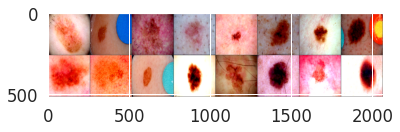

In [ ]:
test_on_1batch(test_loader = test_loader, model = model)

Test Accuracy: 97.33 %
Accuracy of "benign" on test images: 96 %
Accuracy of "malignant" on test images: 98 %


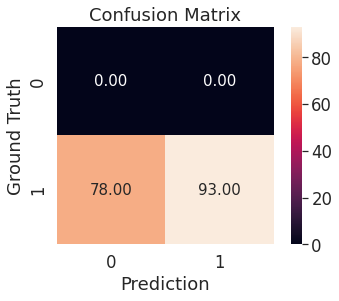

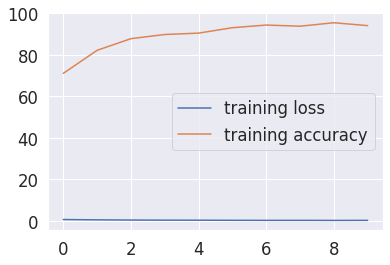

<Figure size 1600x1120 with 0 Axes>

In [ ]:
testing(model = model, criterion = criterion, optimizer = optimizer, total_train_loss = total_train_loss, total_train_acc = total_train_acc)